<a href="https://colab.research.google.com/github/fsacconeUBA/Mossbauer/blob/main/PyMossFit_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción
Se trata de un código Python para ajustar espectros Mossbauer obtenidos en espectrómetros de fuentes con movimientos de aceleración constante. (Ver: https://en.m.wikipedia.org/wiki/M%C3%B6ssbauer_spectroscopy). \
# Descripción
En la primer celda se importan las librerías necesarias de *Numpy, Scipy, Pandas, Pathlib, y Matplotlib*. Además, se instala *Lmfit* con el que se hará la regresión lineal.
Si bien no se requiere que esta notebook esté en el mismo directorio Drive donde se encuentra el archivo de datos, se recomienda, ya que cada modelo de ajuste requiere una notebook específica. La variable *img* es la ruta de acceso (path) del directorio y se debe adecuar a la ubicación del archivo de datos

In [ ]:
"""
V7 incluye ingreso de tipos y cantidades de subespectros, sus parámetros, doblado con FFT y suavizado con Savizky-Golay (recomendable solo p/calibraciones de baja estadística) y un ajuste lineal con lmfit.
Además, se incluye la opción de identificación de fases en una Base de Datos mediante un algoritmo de ML basado en K-Nearest Neighbors (KNN)
Preparando para Colab e importando librerías necesarias.
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu/Iguazu01.Asc'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Parameters, minimize, fit_report, Model
from scipy.optimize import curve_fit
from scipy.constants import *
from scipy.integrate import trapezoid as trapz
from scipy.signal import savgol_filter
from scipy.stats import norm
from pathlib import Path

path= Path(img); file= path.stem; title= path.parent.name; full= path.parents[0]; print(file, title, full)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.9 MB/s eta 0:00:00
Mounted at /content/drive/
Iguazu01 Iguazu /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu


El plegado se hace empleando la librería 'fft' de *Numpy* (Transformada de Fourier Discreta) que permite determinar el mínimo o máximo local en la zona central del espectro de Fourier, que corresponde al canal de doblado, según se define a partir del teorema de Nyquist-Shannon (https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html). \

Para determinar el canal de plegado se debe seleccionar *idmax* o *idmin* según corresponda y ajustar el entorno alrededor del canal de plegado. \

Hay una línea opcional, comentada con el símbolo #, que sirve para suavizar espectros con mucho ruido estadístico mediante el algoritmo Savitzky-Golay. Se lo recomienda solo para calibraciones ya que suelen medirse durante menos tiempo.
En esta sección se genera el archivo $calib.txt$ que guardará la información de la fecha de calibración, la $V_{max}$ que define los mm/s por canal y el número de canales del espectrómetro. Además, el archivo $.csv$ que tendrá dos columnas: $V(mm/s)$ y el espectro doblado y normalizado.

Ingrese la fecha de calibración (AAAAMMDD): 20150304
Ingrese el rango de V (en mm/s): -13.5


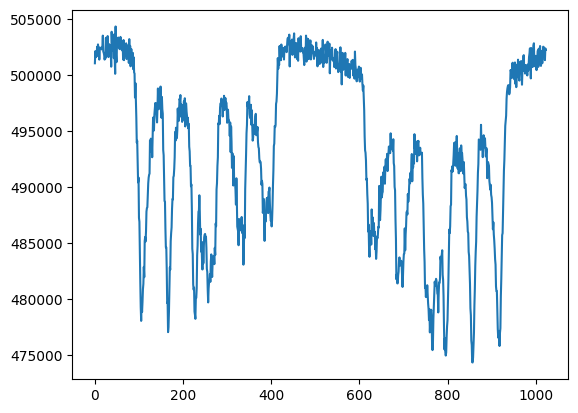

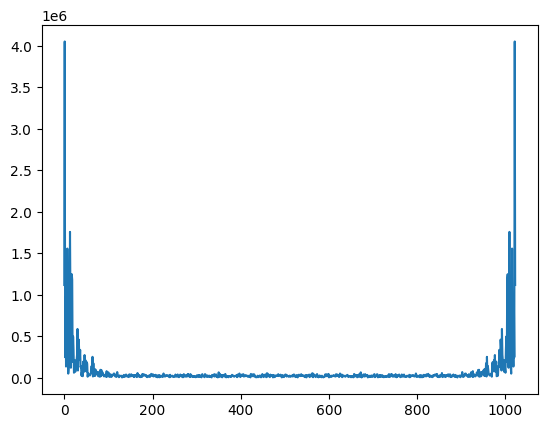

Media del fondo: 1003960
Canal de doblado: 512


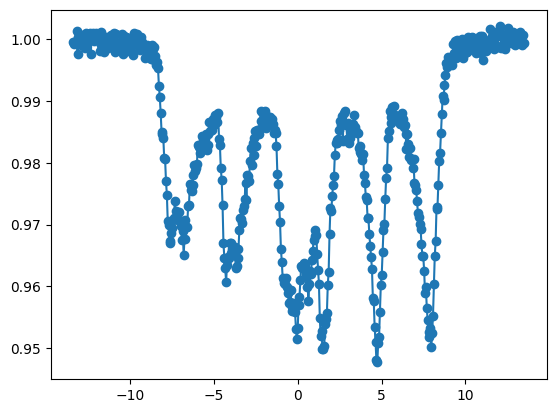

In [ ]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de INTECIN de 1024 canales o CNEA de 512
"""
y= np.loadtxt(img, skiprows=0); #y=y[:,1] #agregar delivery=" " o delimiter=" " en loadtxt si es de dos columnas. Caso contrario comentar y=y[:,1]
N=len(y); N2=int(N/2); N4=int(N/4)

fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )
np.savetxt(f"{full}/{file}-calib.txt", (fecha,vel, N), fmt='%s')

#y= savgol_filter(y, 5, 2) #solo si se trata de espectro con baja estadística, comentar en otro caso
plt.plot(y)
plt.show()

"""
Doblado con FFT (basado en el Nyquist-Shannon sampling theorem, https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html)
"""
f= abs(np.fft.fft(y)); Nf=pd.Series(f[N2-1:N2+1]).idxmax()+(N2-1)
plt.plot(f[1:N])
plt.show()

for i in range(0, Nf-1):
    y[[i]]=y[[i]]+y[[N-1-i]]

y=y[0:N2-1]

"""
Normalización
"""
y2= np.concatenate([y[2:30],y[N2-30:N2-2]])

ymax=np.mean(y2)
ymax=int(ymax)

for i in range(0, N2-1):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,N2)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt(f"{full}/{file}-calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = N2-1, num= N2)

for i in range(0, N2-1):
    x[[i]]=(i-N4)*vmax/N4

x= x[0:N2-1]

print('Media del fondo:', ymax); print('Canal de doblado:', Nf)

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{file}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')

La siguiente celda realiza el ajuste del espectro ya doblado y normalizado en la celda anterior y reporta los parámetros obtenidos. Las funciones de ajuste definidas son Singletes (*singlet, S*), Dobletes (*doublet, Q*) y Sextetes (*sextet, X*) para entornos cristalinos del núcleo sonda y distribuciones para entornos desordenados. Estos últimos son histograma de sextetes (*dist*). Estas funciones se restan al background en Transmisión y se suman en medidas CEMS. \
Cada modelo exige un número de interacciones hiperfinas agregadas en el *y_fit* y se recomienda agregar los parámetros ordenados cardinalmente en cada sección. \
La determinación de las áreas de cada subespectro se realiza con la función *trapz* de *Scipy*. \
Hay dos archivos de salida *plot* (a varias columnas con $V(mm/s)$, datos normalizados, subespectros y el total del modelo) y *report* (que tiene los parámetros hiperfinos finales del ajuste para cada interacción propuesta). El porcentaje relativo de cada subespectro $z_{i}$ se incluye en el archivo de salida *report*.

¿Cuántas funciones Lorentzianas simples necesitas? 1
¿Cuántos dobletes Lorentzianos necesitas? 2
¿Cuántos sextetos Lorentzianos necesitas? 2

--- Configurando Lorentziana 1 ---
Amplitud inicial para Lorentziana 1: 0.05
Centro inicial (mm/s) para Lorentziana 1: 0.46
Ancho inicial (mm/s) para Lorentziana 1: 0.1

--- Configurando Doblete 1 ---
Delta inicial (mm/s) para Doblete 1: 0.3
Quad inicial (mm/s) para Doblete 1: 0.6
Gamma inicial (mm/s) para Doblete 1: 0.1
Escala inicial para Doblete 1: 0.05

--- Configurando Doblete 2 ---
Delta inicial (mm/s) para Doblete 2: 0.3
Quad inicial (mm/s) para Doblete 2: 2.2
Gamma inicial (mm/s) para Doblete 2: 0.1
Escala inicial para Doblete 2: 0.05

--- Configurando Sexteto 1 ---
Delta inicial (mm/s) para Sexteto 1: 0.5
B_hf inicial para Sexteto (mm/s) 1: 8.3
Gamma inicial (mm/s) para Sexteto 1: 0.1
Escala inicial para Sexteto 1: 0.05

--- Configurando Sexteto 2 ---
Delta inicial (mm/s) para Sexteto 2: 0.25
B_hf inicial para Sexteto (mm/s) 2: 9.2
Gamma

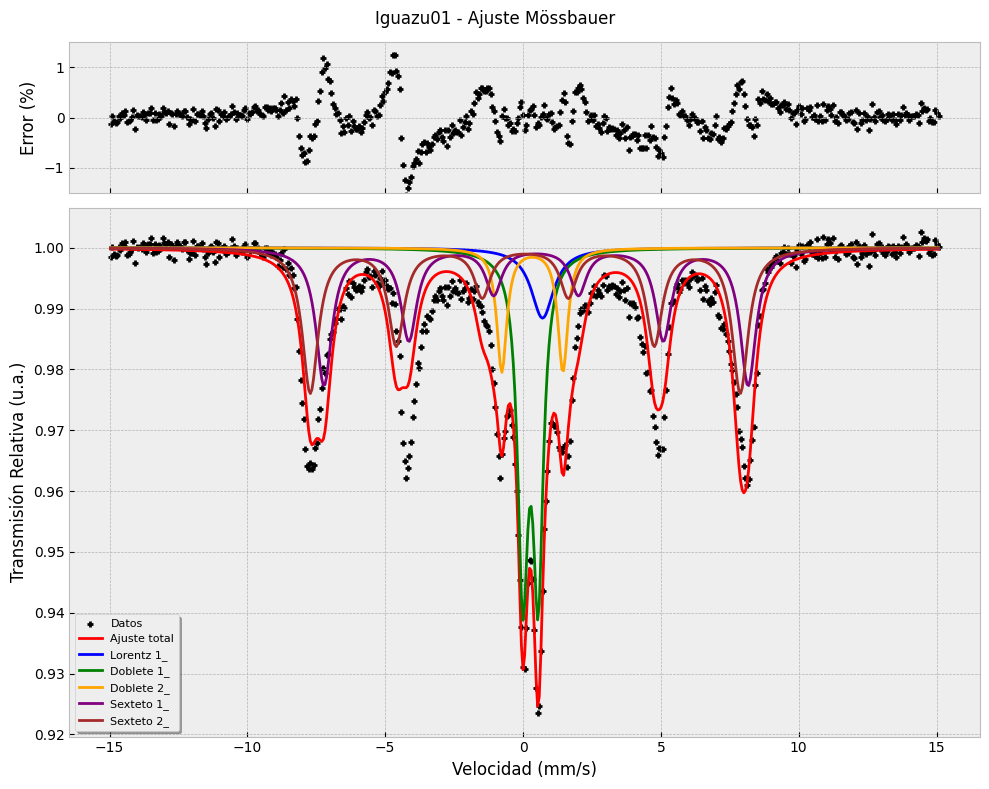

Datos guardados en: /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu/Iguazu01-plot.csv
Reporte de parámetros guardado en: /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu/Iguazu01-report.csv

RESUMEN DEL AJUSTE
    Phase        Tipo  Amplitud  Centro (mm/s)  Ancho (mm/s)  IS (mm/s)  Quad Splitting (mm/s)  Bhf (T)  Area (%)
Lorentz 1 Lorentziana    0.0091         0.7076        0.5000        NaN                    NaN      NaN    5.5544
Doblete 1     Doblete       NaN            NaN        0.2247     0.2716                 0.5572      NaN   23.4156
Doblete 2     Doblete       NaN            NaN        0.2217     0.3388                 2.2169      NaN    8.7394
Sexteto 1     Sexteto       NaN            NaN        0.3500     0.4735                    NaN  47.7882   30.3090
Sexteto 2     Sexteto       NaN            NaN        0.3500     0.0814                    NaN  48.4495   31.9815


In [ ]:
"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{file}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES Y DISTRIBUCIONES BASADAS EN LORENTZIANAS
"""
# Constantes Mössbauer para el doblete (factores de transición entre niveles)
positions_d = np.array([-1 , 1]) / 2  # Relativas a B_hf
intensities_d = np.array([1, 1])  # Relativa intensidad de cada línea

# Constantes Mössbauer para el sexteto (factores de transición entre niveles)
positions_x = np.array([-1., -3/5., -1/5., 1/5, 3/5, 1.])   # Relativas a B_hf
intensities_x = np.array([3, 2, 1., 1., 2, 3])  # Relativa intensidad de cada línea

def lorentzian(x, amplitude, center, width):
    """Función Lorentziana simple"""
    return amplitude * (2*width / ((np.pi) * ((x - center)**2 + width**2)))

def doublet_lorentzian(x, delta, quad, gamma, scale):
    """
    Modelo de doblete de líneas Lorentzianas para un espectro Mössbauer de interacción cuadrupolar.

    Parámetros:
    - delta: desplazamiento isomérico
    - quad: doblete cuadrupolar
    - gamma: ancho de línea de cada componente Lorentziana
    - scale: factor de escala de intensidad
    """
    y = np.zeros_like(x)
    for i, (pos, inten) in enumerate(zip(positions_d, intensities_d)):
        center = delta + pos * quad
        y += lorentzian(x, scale * inten, center, gamma)
    return y

def sextet_lorentzian(x, delta, B_hf, gamma, scale):
    """
    Modelo de sexteto de líneas Lorentzianas para un espectro Mössbauer con un campo magnético.

    Parámetros:
    - delta: desplazamiento isomérico
    - B_hf: campo hiperfino magnético
    - gamma: ancho de línea de cada componente Lorentziana
    - scale: factor de escala de intensidad
    """
    y = np.zeros_like(x)
    for i, (pos, inten) in enumerate(zip(positions_x, intensities_x)):
        center = delta + pos * B_hf
        y += lorentzian(x, scale * inten, center, gamma)
    return y

# Usar lmfit para definir el modelo y realizar el ajuste

# 1. Preguntar al usuario por la cantidad de componentes
n_lorentz = int(input("¿Cuántas funciones Lorentzianas simples necesitas? "))
n_doublet = int(input("¿Cuántos dobletes Lorentzianos necesitas? "))
n_sextet = int(input("¿Cuántos sextetos Lorentzianos necesitas? "))

# 2. Crear modelo combinado dinámicamente
combined_model = Model(lambda x: np.zeros_like(x))
params = Parameters()

# 3. Función para obtener valores iniciales del usuario
def get_initial_values(comp_type, comp_num):
    """
    Pide al usuario los valores iniciales para cada parámetro
    """
    print(f"\n--- Configurando {comp_type} {comp_num} ---")

    if comp_type == 'Lorentziana':
        amplitude = float(input(f"Amplitud inicial para Lorentziana {comp_num}: ") or "0.1")
        center = float(input(f"Centro inicial (mm/s) para Lorentziana {comp_num}: ") or "0.0")
        width = float(input(f"Ancho inicial (mm/s) para Lorentziana {comp_num}: ") or "0.15")
        return {'amplitude': amplitude, 'center': center, 'width': width}

    elif comp_type == 'Doblete':
        delta = float(input(f"Delta inicial (mm/s) para Doblete {comp_num}: ") or "0.3")
        quad = float(input(f"Quad inicial (mm/s) para Doblete {comp_num}: ") or "1.0")
        gamma = float(input(f"Gamma inicial (mm/s) para Doblete {comp_num}: ") or "0.15")
        scale = float(input(f"Escala inicial para Doblete {comp_num}: ") or "0.2")
        return {'delta': delta, 'quad': quad, 'gamma': gamma, 'scale': scale}

    elif comp_type == 'Sexteto':
        delta = float(input(f"Delta inicial (mm/s) para Sexteto {comp_num}: ") or "0.5")
        B_hf = float(input(f"B_hf inicial para Sexteto (mm/s) {comp_num}: ") or "2.5")
        gamma = float(input(f"Gamma inicial (mm/s) para Sexteto {comp_num}: ") or "0.25")
        scale = float(input(f"Escala inicial para Sexteto {comp_num}: ") or "0.2")
        return {'delta': delta, 'B_hf': B_hf, 'gamma': gamma, 'scale': scale}

# 4. Agregar Lorentzianas simples con values individuales
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    initial_vals = get_initial_values('Lorentziana', i+1)

    combined_model += Model(lorentzian, prefix=prefix)
    params.add_many(
        (f'{prefix}amplitude', initial_vals['amplitude'], True, 0, 1),
        (f'{prefix}center', initial_vals['center'], True, -2, 2),
        (f'{prefix}width', initial_vals['width'], True, 0.05, 0.5)
    )

# 5. Agregar dobletes con values individuales
for i in range(n_doublet):
    prefix = f'd{i+1}_'
    initial_vals = get_initial_values('Doblete', i+1)

    combined_model += Model(doublet_lorentzian, prefix=prefix)
    params.add_many(
        (f'{prefix}delta', initial_vals['delta'], True, -0.7, 1.5),
        (f'{prefix}quad', initial_vals['quad'], True, 0, 2.5),
        (f'{prefix}gamma', initial_vals['gamma'], True, 0.0, 0.35),
        (f'{prefix}scale', initial_vals['scale'], True, 0.0, 1)
    )

# 6. Agregar sextetos con values individuales
for i in range(n_sextet):
    prefix = f'x{i+1}_'
    initial_vals = get_initial_values('Sexteto', i+1)

    combined_model += Model(sextet_lorentzian, prefix=prefix)
    params.add_many(
        (f'{prefix}delta', initial_vals['delta'], True, -0.7, 1.5),
        (f'{prefix}B_hf', initial_vals['B_hf'], True, 0, 8.5),
        (f'{prefix}gamma', initial_vals['gamma'], True, 0.0, 0.35),
        (f'{prefix}scale', initial_vals['scale'], True, 0.0, 1)
    )
"""
# 7. Eliminar modelo base vacío
if n_lorentz + n_doublet + n_sextet > 0:
    combined_model = sum(combined_model[1:])
else:
    raise ValueError("Debe haber al menos un componente en el modelo")
"""
# Configurar parámetros iniciales y límites

def linear_fitting_lmfit(params, x, y):
    y_fit= 1-combined_model.eval(params=params, x=x)

    return y_fit-y

# Extraer resultados y guardarlos en un DataFrame
param_headers = []
param_values = []
param_errors = []

# Ajuste usando el método de mínimos cuadrados
result = minimize(linear_fitting_lmfit, params, args=(x,y), method='least_squares')
best_fit= 1-combined_model.eval(params=result.params, x=x)

# Calculate fits for each component individually
component_fits = {}
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    component_fits[prefix] = lorentzian(x, result.params[f'{prefix}amplitude'].value,
                                       result.params[f'{prefix}center'].value,
                                       result.params[f'{prefix}width'].value)

for i in range(n_doublet):
    prefix = f'd{i+1}_'
    component_fits[prefix] = doublet_lorentzian(x, result.params[f'{prefix}delta'].value,
                                              result.params[f'{prefix}quad'].value,
                                              result.params[f'{prefix}gamma'].value,
                                              result.params[f'{prefix}scale'].value)

for i in range(n_sextet):
    prefix = f'x{i+1}_'
    component_fits[prefix] = sextet_lorentzian(x, result.params[f'{prefix}delta'].value,
                                             result.params[f'{prefix}B_hf'].value,
                                             result.params[f'{prefix}gamma'].value, # Corrected parameter name
                                             result.params[f'{prefix}scale'].value)


for name, param in result.params.items():
      param_headers.append(name)
      param_values.append(param.value)
      param_errors.append(param.stderr)

# CALCULAR ÁREAS CORRECTAMENTE

def calculate_areas(x, component_fits):

    """
    Calcula áreas relativas correctamente para componentes Mössbauer
    """
    areas = {}
    total_absorption = 0

    # Calcular área total de absorción (1 - transmisión total)
    total_fit = np.zeros_like(x)
    for fit in component_fits.values():
        total_fit += fit

    total_absorption_area = trapz(total_fit, x)

    # Calcular área de cada componente
    for prefix, fit in component_fits.items():
        # For Mössbauer, area is proportional to the integral of (1 - component_transmission)
        # Here component_fits are already defined as (1-transmission_component)
        component_area = trapz(fit, x)
        areas[prefix] = (component_area / total_absorption_area) * 100 if total_absorption_area != 0 else 0

    return areas

# Usar la función corregida
component_areas = calculate_areas(x, component_fits)

# Calcular error
e= (y-best_fit)/y*100

# Imprimir resultados del ajuste
print(fit_report(result))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
# GRAFICA DINÁMICA
plt.style.use('bmh')
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), height_ratios=[1,3.5])
fig.suptitle(f"{file} - Ajuste Mössbauer")

# Gráfica de error
ax1.scatter(x, e, c='black', marker='+', s=20)
ax1.set_ylim(-1.5, 1.5)
ax1.set_ylabel('Error (%)')

# Gráfica principal
ax2.scatter(x, y, c='black', marker='+', s=20, label='Datos')
ax2.plot(x, best_fit, c='red', linewidth=2, label='Ajuste total')

# Colores para diferentes componentes
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'black', 'gray', 'olive']

# Graficar cada componente
color_idx = 0
for prefix, fit in component_fits.items():
    comp_type = prefix[0]  # 'l', 'd' o 'x'
    comp_num = prefix[1:]  # '1_', '2_', etc.

    if comp_type == 'l':
        label = f'Lorentz {comp_num}'
    elif comp_type == 'd':
        label = f'Doblete {comp_num}'
    else:
        label = f'Sexteto {comp_num}'

    ax2.plot(x, 1 - fit, c=colors[color_idx % len(colors)], label=label)
    color_idx += 1

ax2.set_xlabel('Velocidad (mm/s)')
ax2.set_ylabel('Transmisión Relativa (u.a.)')
ax2.legend(handlelength=2, loc='lower left', shadow=True, fontsize=8)
plt.tight_layout()

plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA USANDO PANDAS
"""

# Crear DataFrame con datos principales
plot_data = pd.DataFrame({
    'x': x,
    'y': y,
    'best_fit': best_fit
})

# Agregar componentes dinámicamente al DataFrame
# Lorentzianas simples
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    fit = lorentzian(x, result.params[f'{prefix}amplitude'].value,
                    result.params[f'{prefix}center'].value,
                    result.params[f'{prefix}width'].value)
    plot_data[f'Lorentz_{i+1}'] = fit

# Dobletes
for i in range(n_doublet):
    prefix = f'd{i+1}_'
    fit = doublet_lorentzian(x, result.params[f'{prefix}delta'].value,
                            result.params[f'{prefix}quad'].value,
                            result.params[f'{prefix}gamma'].value,
                            result.params[f'{prefix}scale'].value)
    plot_data[f'Doublet_{i+1}'] = fit

# Sextetos
for i in range(n_sextet):
    prefix = f'x{i+1}_'
    fit = sextet_lorentzian(x, result.params[f'{prefix}delta'].value,
                           result.params[f'{prefix}B_hf'].value,
                           result.params[f'{prefix}gamma'].value, # Corrected parameter name
                           result.params[f'{prefix}scale'].value)
    plot_data[f'Sextet_{i+1}'] = fit

# Guardar DataFrame como CSV
plot_data.to_csv(f"{full}/{file}-plot.csv", index=False, float_format='%.6e')
print(f"Datos guardados en: {full}/{file}-plot.csv")

"""
GENERACIÓN DEL DATAFRAME DE RESULTADOS MEJORADO
"""

data_for_df = []

# Lorentzianas simples
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    data_for_df.append({
        'Phase': f'Lorentz {i+1}',
        'Tipo': 'Lorentziana',
        'Amplitud': result.params[f'{prefix}amplitude'].value,
        'Centro (mm/s)': result.params[f'{prefix}center'].value,
        'Ancho (mm/s)': result.params[f'{prefix}width'].value,
        'IS (mm/s)': np.nan,
        'Quad Splitting (mm/s)': np.nan,
        'Bhf (T)': np.nan,
        'Area (%)': component_areas.get(prefix, 0)
    })

# Dobletes
for i in range(n_doublet):
    prefix = f'd{i+1}_'
    data_for_df.append({
        'Phase': f'Doblete {i+1}',
        'Tipo': 'Doblete',
        'Amplitud': np.nan,
        'Centro (mm/s)': np.nan,
        'Ancho (mm/s)': result.params[f'{prefix}gamma'].value,
        'IS (mm/s)': result.params[f'{prefix}delta'].value,
        'Quad Splitting (mm/s)': result.params[f'{prefix}quad'].value,
        'Bhf (T)': np.nan,
        'Area (%)': component_areas.get(prefix, 0)
    })

# Sextetos
for i in range(n_sextet):
    prefix = f'x{i+1}_'
    Bhf =  33 / 5.312 * result.params[f'{prefix}B_hf'].value
    data_for_df.append({
        'Phase': f'Sexteto {i+1}',
        'Tipo': 'Sexteto',
        'Amplitud': np.nan,
        'Centro (mm/s)': np.nan,
        'Ancho (mm/s)': result.params[f'{prefix}gamma'].value,
        'IS (mm/s)': result.params[f'{prefix}delta'].value,
        'Quad Splitting (mm/s)': np.nan,
        'Bhf (T)': Bhf,
        'Area (%)': component_areas.get(prefix, 0)
    })

# Crear y guardar DataFrame
df = pd.DataFrame(data_for_df)

# Redondear valores para mejor presentación
numeric_columns = ['Amplitud', 'Centro (mm/s)', 'Ancho (mm/s)', 'IS (mm/s)',
                   'Quad Splitting (mm/s)', 'Bhf (T)', 'Area (%)']
for col in numeric_columns:
    if col in df.columns:
        df[col] = df[col].round(4)

df.to_csv(f"{full}/{file}-report.csv", index=False)
print(f"Reporte de parámetros guardado en: {full}/{file}-report.csv")

# Mostrar resumen en consola
print("\n" + "="*50)
print("RESUMEN DEL AJUSTE")
print("="*50)
print(df.to_string(index=False))

La siguiente sección del código permite identificar las fases presentes en la muestra, a partir de los resultados del ajuste, comparando los parámetros de los subespectros con una base de datos en formato CSV. Se cuenta con una base de datos de unos +50 compuestos de Fe con sus datos de espectros Mossbauer de $^{57}Fe$. (Se puede saltear si se conocen las fases presentes)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Cargar datos de referencia (base de datos)
reference_path = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/reference_data.csv'  # ¡Ajusta la ruta!
df_ref = pd.read_csv(reference_path)

# Función para convertir rangos a valores medios (ej: "0.37-0.45" → 0.41)
def parse_value(value):
    if isinstance(value, str) and '-' in value:
        min_val, max_val = map(float, value.split('-'))
        return (min_val + max_val) / 2
    return float(value)

# Procesar columnas relevantes
cols = ['IS (mm/s)', 'Quad Splitting (mm/s)', 'Bhf (T)']
for col in cols:
    df_ref[col] = df_ref[col].apply(parse_value)

# 3. Cargar datos experimentales
experimental_path = f"{full}/{file}-report.csv"  # ¡Ajusta la ruta!
df_exp = pd.read_csv(experimental_path)

# 4. Preprocesar datos experimentales (manejar NaN)
X_exp = df_exp[cols].fillna(0).values  # Si Bhf no existe, reemplazar NaN por 0

# 5. Entrenar modelo KNN
X_ref = df_ref[cols].values
model = NearestNeighbors(n_neighbors=3, metric='euclidean')
model.fit(X_ref)

# 6. Encontrar coincidencias
distances, indices = model.kneighbors(X_exp)

# 7. Mostrar resultados
for i, (dist, idx) in enumerate(zip(distances, indices)):
    print(f"\nMuestra experimental {i+1}:")
    for j, (d, pos) in enumerate(zip(dist, idx)):
        compound = df_ref.iloc[pos]['Compound Name']
        formula = df_ref.iloc[pos]['Chemical Formula']
        is_ref = df_ref.iloc[pos]['IS (mm/s)']
        qs_ref = df_ref.iloc[pos]['Quad Splitting (mm/s)']
        bhf_ref = df_ref.iloc[pos]['Bhf (T)']
        print(f"  Match {j+1}: {compound} ({formula})")
        print(f"    IS: {is_ref:.2f} mm/s | QS: {qs_ref:.2f} mm/s | Bhf: {bhf_ref:.1f} T")
        print(f"    Distancia euclidiana: {d:.2f}\n")

print("## Usar este resultado a modo orientativo. Se recomienda contar con información de la muestra en su composición y estructura ##")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Muestra experimental 1:
  Match 1: Ti-espinela (Fe2TiO4)
    IS: 0.83 mm/s | QS: 1.91 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.32

  Match 2: Nitroprusiato de sodio (Na₂[Fe(CN)₅NO])
    IS: 0.10 mm/s | QS: 1.70 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.44

  Match 3: FeWO₄ (FeWO₄)
    IS: 0.95 mm/s | QS: 1.65 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.47


Muestra experimental 2:
  Match 1: Pyrite (FeS₂)
    IS: 0.32 mm/s | QS: 0.62 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.05

  Match 2: FePO₄ (FePO₄)
    IS: 0.40 mm/s | QS: 0.60 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.06

  Match 3: Ferrihydrite (Fe₅HO₈·4H₂O)
    IS: 0.40 mm/s | QS: 0.60 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.06


Muestra experimental 3:
  Match 1: Fe₃O₄ nanoparticles (Fe₃O₄)
    IS: 0.28 mm/s | QS: 0.00 mm/s | Bhf: 48.5 T
    Distancia euclidiana: 0.52

  Matc